In [19]:
from torch_geometric.datasets import Planetoid
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import numpy as np
import networkx as nx
import pandas as pd
from torch_geometric.data import Data
import ast
from torch_geometric.utils.convert import from_networkx
from torch_geometric.transforms import RandomNodeSplit
from sklearn.metrics import f1_score

In [2]:
#dataset provided with pythorch package
dataset1 = Planetoid(root='/tmp/Cora', name='Cora')
print(dataset1[0])

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [3]:
# Load edge information from edges.csv
edges_df = pd.read_csv('edges.csv')

# Load node information from nodes.csv
nodes_df = pd.read_csv('nodes.csv', index_col = 0)

In [4]:
edges_df.head()

,Unnamed: 0,sourceNodeId,targetNodeId,relationshipType
0,0,35,1033,CITES
1,1,35,103482,CITES
2,2,35,103515,CITES
3,3,35,1050679,CITES
4,4,35,1103960,CITES


In [5]:
#make feature tensor
nodes = nodes_df.drop(['labels'], axis=1)
labels = nodes["subject"]
features = nodes["features"].apply(ast.literal_eval).apply(lambda x: np.array(x, dtype=np.float32))
feature_tensor = torch.tensor(features.tolist(), dtype=torch.float32)

<ipython-input-5-99d3457feb31>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  feature_tensor = torch.tensor(features.tolist(), dtype=torch.float32)


In [6]:
#create new id mapping for nodes (to be in range [0,2708])
NODE_ID_MAPPING = {}
for i, nid in nodes_df["nodeId"].items():
    #print(i, nid)
    NODE_ID_MAPPING[nid] = i

In [7]:
#apply id mapping to edges
edges_df["mapped_source"] = edges_df["sourceNodeId"].apply(lambda x: NODE_ID_MAPPING[x])
edges_df["mapped_target"] = edges_df["targetNodeId"].apply(lambda x: NODE_ID_MAPPING[x])
edges_df.head()

edges = edges_df[['mapped_source', 'mapped_target']].values.T

In [8]:
# Convert labels to numerical encoding
label_mapping = {label: i for i, label in enumerate(set(labels))}
#numerical_labels = [label_mapping[label] for label in labels]
numerical_labels = labels.apply(lambda x: label_mapping[x])

In [10]:
#load dataset
#graph = nx.Graph()
#graph.add_edges_from(edges.T)


# Convert the NetworkX graph to a PyTorch Data object
dataset = Data(
    x= feature_tensor,
    y=torch.LongTensor(numerical_labels),
    edge_index=torch.LongTensor(edges).contiguous(),
    num_classes = len(label_mapping)
)

In [11]:
#add train test split
transform = RandomNodeSplit(split="random", num_val=0.1, num_train_per_class=40, num_test=0.3)
dataset = transform(dataset)

In [12]:
print(dataset.edge_index)

tensor([[ 163,  163,  163,  ..., 2258, 1887, 1686],
        [ 402,  659, 1696,  ..., 1887, 1902,  837]])


In [13]:
#make 1433 - 128 - 16 - 7 GCN
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16, aggr="add")
        self.conv2 = GCNConv(16, dataset.num_classes,aggr="add")
        #self.conv3 = GCNConv(16, dataset.num_classes,aggr="add")

    def forward(self, data, **kwargs):        
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        if kwargs.get("layer", None) == 1:
            return x
        
        x = self.conv2(x, edge_index)
        # x = F.relu(x)

        if kwargs.get("layer", None) == 2:
            return x
        
        # if kwargs.get("layer", None) == 2:
        #     return x
        
        # x = self.conv3(x, edge_index)

        return F.log_softmax(x, dim=1)
    
    def get_embedding(self, data, layer:int):
        # Set the model to evaluation mode
        self.eval()
        
        kwargs = {"layer": layer}
        
        with torch.no_grad():
            embeddings = self.forward(data, **kwargs)
            
        return embeddings

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(70):
    optimizer.zero_grad()
    out = model(data)
    #loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [17]:
model.eval()
pred = model(data).argmax(dim=1)
correct_train = (pred[data.train_mask] == data.y[data.train_mask]).sum()
acc_train = int(correct_train) / int(data.train_mask.sum())
correct_test = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc_test = int(correct_test) / int(data.test_mask.sum())
print(f'Accuracy Train: {acc_train:.4f}')
print(f'Accuracy Test: {acc_test:.4f}')

Accuracy Train: 0.9964
Accuracy Test: 0.8091


In [22]:
f1_score(data.y[data.test_mask], pred[data.test_mask], average="micro")

0.8012279917547798

In [24]:
embeddings = model.get_embedding(data,3)

In [26]:
embeddings[0]

tensor([-5.0543, -5.3540, -6.3508, -0.4787, -4.1050, -1.0638, -5.1257])

c:\Users\schmi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\schmi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


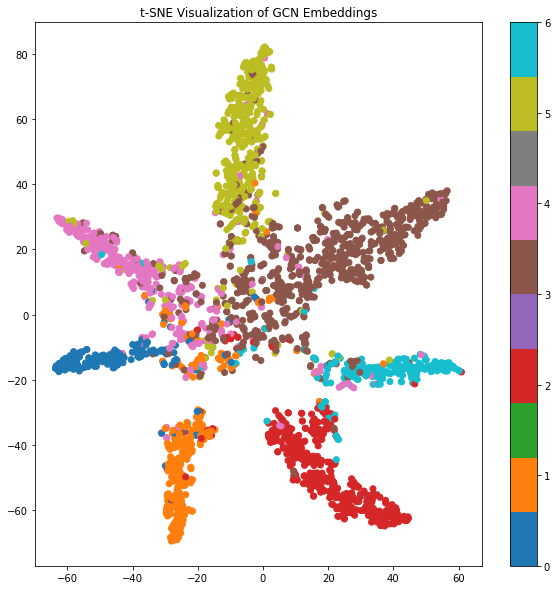

In [27]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming you have the GCN embeddings stored in a variable called "embeddings"
# Shape of "embeddings": (num_samples, embedding_dim)

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

# Assuming you have the ground truth labels stored in a variable called "labels"
# Shape of "labels": (num_samples,)

# Plot the t-SNE representation with colored labels
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=data.y, cmap='tab10')
plt.title("t-SNE Visualization of GCN Embeddings")
plt.colorbar()
plt.show()